# Compute Phase using Iterative Relative Phase Measurements
#### Ben Nativi with Professor Calderbank

The goal of this program is to find the eigenbases for the maximal commutative subgroups Sa and Ta for the Heisenberg-Weyl Group $HW_N$ given some choice of binary tuple a of length m.

This version of the program relies on an algorithm designed by Trung Can.

### Useful np functions
np.array( [ [], [] ] )

np.matmul(matrix1, matrix2)

np.kron(matrix1, matrix2)

np.transpose(matrix)

np.linalg.eig(matrix) outputs: eigenvalue array, normalized eigenvector array 
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.eig.html

numpy.diag(v, k=0)[source] 
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.diag.html

numpy.identity(m)

numpy.zeros( (m,m) )

# Helper Functions

The list of helper functions is:

reverseBin(binary)

intToBin(num,N)

binToInt(binary)

xorInt(one, two)

--------------------
D(a,b)

E(a,b)

createOmega_a(aBin,N)

createNOmega_a(aBin,N)

--------------------
validA(a,m)

--------------------
sympInProd(a,b,m)

makeHN(m)

makeIN(m)

--------------------
getQSa(a,m)

getPSa(a,m)

getPTa(a,m)

--------------------
diagTP(P,m)

permQ(Q,m)

getGk(k,m)

-------------------
check(one, two)

cleanUp(matrix)

cleanUp2(matrix)

roundComplex(complexNum)

-------------------
getSaTaBases(a,m)

-------------------
sympTP(P,m)

sympAQ(Q,m)

sympGk(k,m)

get_c(aBin,bBin,m,G)

-------------------
extra(aBin,bBin)

buildEigvalMat(a,m)

buildEigvec(x,a,m) - no longer needed

relativePhase(x,a,m) - no longer needed

check3(vec1,vec2)

getPhase(vec) - no longer needed

-------------------
complexRandomNoise(deviation)

generateX(size,magnitude)

buildEigvecNoise(x,a,m,deviation)

relativePhaseNoise(x,a,m,deviation)

getPhaseNoise(x,deviation)

testAlgForVariance(trials,size,magnitude,deviation)

testRelPhasForVariance(trials,m,magnitude,deviation)

-------------------
getPhaseNoiseOpt(x,deviation)

testOptAlgCorrectness(trials,size,magnitude,deviation)

testOptAlgForVariance(trials,size,magnitude,deviation)

-------------
### NOTE
#### mean squared error only depends on the ratio mag^2/dev
For a given ratio, the mean squared error always follows the same pattern.  For the original algorithm, the mean squared error increases by 30-50% with each increment of m, and with optimized algorithm (modifying signal), the mean squared error increases by 5-10% with each increment increasing m.

Also the optimized algorithm in all cases performes approximately 3x better than the original algorithm.

In [1]:
#imports

# Tell Python to include plots as embedded graphics.
%matplotlib inline

# Import plotting
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

# Import numpy, and library commands
import numpy as np
import math
import random as r
from tqdm import tqdm_notebook as tqdm
import time
from collections import deque
r.seed(1717)
np.random.seed(1717);



from scipy.stats import chisquare

import sympy # for finding linearly independent rows to get generating set

import itertools # used for combinations and permutations

In [5]:
# methods used for phase recovery
from utils.binary_operations import *
from utils.random import *

from utils.heisenberg_weyl_methods import *
from utils.relative_phase import *
from utils.relative_phase_noise import *

from utils.get_phase_original_noiseless import *
from utils.get_phase_original_noise import *
from utils.get_phase_ASMT import *
from utils.get_phase_bipartite import *
from utils.get_phase_largest_two import *
from utils.get_phase_projections import *
from utils.get_phase_projections_unweighted import *

from utils.test1 import *
from utils.test2 import *
from utils.simulations1 import *

from utils.Mixon_comparison_1 import *
from utils.Mixon_comparison_2 import *

In [6]:
run = 0 #testing get_phase_original and get_phase_noise
if run:
    for i in range(10):
        x = generate_x_uniform(16, 100000)
    #     print(x)
        x_hat = get_phase_noise(x,0.001)
    #     print(x_hat)
        check3(x,x_hat)

In [7]:
#Test code for get_phase_noise

run = 0 #controls whether the test code runs, set to 1 to run this code

if (run):
    deviation = 0.1
    #test 1
    x = [ 2, -1, 1-1j, 1j]
    v = getPhaseNoise(x,deviation)
    print(x)
    print(v)
    print

    #test 2
    x = [ 1, 2, 1j, 3j, -1, -5, -1j, -7j]
    v = getPhaseNoise(x,deviation)
    print(x)
    print(v)
    print

#     #test 3
#     #vector of length 512
    x = [ 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j]
    v = getPhase(x)
    check3(v,x)
    print

In [8]:
#Test code for the effects of Gaussian noise on our computations of phase

run = 0 #controls whether the test code runs, set to 1 to run this code

if (run):
    trials = 1000
    magnitude = 1
    deviation = 1
    
    print(testAlgForVariance(trials, 4, magnitude, deviation))
    print()
    
    print("====================================================")
    print(testAlgForVariance(trials, 8, magnitude, deviation))
    print()
        
    print("====================================================")
    print(testAlgForVariance(trials, 16, magnitude, deviation))
    print()

In [9]:
#Test code for the effects of Gaussian noise on our computations of RELATIVE PHASE

#NOTES
# magnitude and trials do not affect results, which is as desired
# the variances of entries seem to be increasing with the size of the vector at a quadratic rate
# the variance for a vector of length n appears to be n^2

run = 0 #controls whether the test code runs, set to 1 to run this code

if (run):
    a = 1
    trials = 1000
    magnitude = 1
    deviation = 1
    
    print(testRelPhasForVariance(trials,1,magnitude,deviation))
    
    print("====================================================")
    print(testRelPhasForVariance(trials,2,magnitude,deviation))
    
    print("====================================================")
    print(testRelPhasForVariance(trials,3,magnitude,deviation))
        
    print("====================================================")
    print(testRelPhasForVariance(trials,4,magnitude,deviation))

In [10]:
# code to check that getPhaseNoiseNew correctly returns x when there is no noise
# appears that the new optimized getPhaseNoiseNew method correctly computed x on 2/12/19

run = 0

if (run):
    trials = 1000
    magnitude = 10
    deviation = 1
    
    print(testOptAlgCorrectness(trials,4,magnitude,0))
    print(testOptAlgCorrectness(trials,4,magnitude,deviation))

In [11]:
# Test code for the effects of Gaussian noise on our computations of phase with the new optimized algorithm
# compare old algorithm to the new algorithm

# working 9/21/19

run = 0 #controls whether the test code runs, set to 1 to run this code    

if (run):
    trials = 100
    magnitude = 1  # approximate magnitude of each x_i
    deviation = 0.00000000000001   # standard deviation
    
    print("trials =", trials)
    print("magnitude =", magnitude)
    print("deviation =", deviation)
    print
    print("m = 1")
    print
    print(test_alg_for_variance(trials, 2, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 2, magnitude, deviation))
    print
    
    print("--------------------------------------------------------")
    print
    print("m = 2")
    print
    print(test_alg_for_variance(trials, 4, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 4, magnitude, deviation))
    print
    
    print("--------------------------------------------------------")
    print
    print("m = 3")
    print
    print(test_alg_for_variance(trials, 8, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 8, magnitude, deviation))
    print
    
    print("--------------------------------------------------------")
    print
    print("m = 4")
    print
    print(test_alg_for_variance(trials, 16, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 16, magnitude, deviation))
    print
    
#     print("--------------------------------------------------------"
#     print
#     print("m = 5"
#     print(test_alg_for_variance(trials, 32, magnitude, deviation)
#     print
#     print(test_ASMT_relative_error(trials, 32, magnitude, deviation)
#     print(

In [12]:
# code that generates random vectors x of size 2 to test our observation about the relative phase measurements

# x = np.array([2+3j, 5-2j]);
# deviation = 0
# a = 1
# m = 1

# for i in range(1000):
#     x = generateX(2,5)
# #     print(x

#     relativePhaseNoise2(x,a,m,deviation)
# #     print
# #     print
# #     print(getPhaseNoiseOpt(x,deviation)

In [13]:
# (trials, startMag, startDev, increments, m, increaseFactor)

# working 9/21/19

run = 0
if run:
    NSRvsMSE(300, 10, 1.0, 20, 2, 1.2)

In [14]:
# (trials, startMag, startDev, increments, m, increaseFactor)
run = 0
if run:
    NSRvsMSE(500, 10, 1.0, 15, 3, 1.2)

In [15]:
# (trials, startMag, startDev, increments, m, increaseFactor)
run = 0
if run:
    NSRvsMSE(200, 10, 1.0, 8, 4, 1.2)

In [16]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(20000, 0.3, np.sqrt(10**1), 1)

In [17]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(20000, 0.3, np.sqrt(10**2), 1)

In [18]:
# (trials, trialFactor, magnitude, deviation)

#

run = 0
if run:
    MvsMSE(1000, 0.3, np.sqrt(10**3), 1)

In [19]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(20000, 0.3, np.sqrt(10**6), 1)

In [20]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(10000, 0.3, np.sqrt(10**6), 1)

In [21]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(10000, 0.3, np.sqrt(10**9), 1)

# Work 7/26/19 
getPhaseNoise with simple bipartite approach.  This algorithm should theoretically be the best possible way we can take measurements using our measurement scheme.  I am treating our vector as a bipartite graph where each even entry of the vector is on one side and the odd entries are on the other side of teh graph.  Any valid choice of a (i.e. an odd choice of a) will link an vertex of one side to the other.  Because we cannot use even a, we cannot connect even vertices to even or odd to odd.  Thus this graph is bipartite.  However we can also connect any even entry to all odd vertices and vice versa.  This is because there are N/2 odd vertices and there are N/2 valid choices of a, and each choice of a will connect an even vertex to a unique odd vertex.  Thus the entries of one side are fully connected to the entries of the other side.

This suggests that the ultimately optimal measurement scheme is quite simple.  We get a better estimate for an entry when the entry we are measuring from has a larger magnitude, because we divide the noise term of the relative phase by the phase of this entry.  Then the best way to measure any even vertex is to make the measurement from the largest odd vertex.  Similarly the best way to measure any odd vertex is from the largest even vertex.  So what we do is:
* take a magnitude measurement of all the vertices, say the largest magnitude entry is even
* use the largest magnitude vertex (the even one) to get a relative phase measurement for each odd vertex on the other side of the bipartite graph, giving an estimate for all odd entries
* use the largest magnitude odd vertex along with its estimated phase to estimate each of the even vertices other than the vertex we started from

This will produce an estimate for the entire vector.  It is optimal because any relative phase measurement that is not FROM the largest even or odd vertex will produce an estimate for the phase of that entry that is less optimal than it otherwise could have been if the measurment was used more wisely.  

#### RECALL

In my programming, binary numbers are written with the most significant number on the left, i.e. 10 = 2

# Work 7/29/19

I now have the getPhaseNoiseBipartite algorithm working.  I created the algorithm without using the Altered Signal Measurement Technique, as using the ASMT would allow us to recover absolute phase (i.e. not up to a global phase factor) which doesn't really make any sense.  I could try using the ASMT but using (global_phase_factor)*x_hat[index] to compare Opt and Bipartite with the ASMT.

As my tests have shown that the ASMT doesn't make much of a difference when the NSR is large, I think I will keep my Bipartite algorithm without ASMT for now.  

I am now attempting to test performance of Bipartite vs. Opt vs. Original.  

Some initial tests on trial sizes of 500 show that Bipartite is on average has half the MSE as OPT and anywhere from 3 to 6 times smaller MSE than the Original.

# Work 7/30/19

I first added and tested code that allows the Bipartite algorithm to run on vectors of any length, not just a power of 2.  This works by appending 0's to the vector to make a new vector whos length is a vector of two, and "forgetting" these extra entries when I return x_hat in the end.  I do technically now make more measurements than I should as I estimate the new entries that I create, but this shouldn't really cause any problems because in reality, we just wouldn't make those measurements.  I could change the algorithm to reflect that, but that would be a good deal of work and wouldn't really provide us with any benefit, as we know the number of measurements we are making for a vector of length N.

I am now developing tests to compare the bipartite algorithm with the Mixon algorithm.  In their paper, they give rather explicit instructions on how they ran their simulations, so I should be able to draw x from the same distribution and use the same distribution for the complex noise and be able to compare results.  

# Work 9/5/19
I just got access to Mixon's code for the paper "Phase Retrieval with Polarization".  I spent about 5 hours working on using his Matlab code to make comparisons with my algorithm.  I designed new modified algorithms that allow me to use the same vectors that were used in the Matlab program to compare how my algorithm performs.  I did so by copying the matlab output into a textfile which could be read off in python to build each x.  I also added functionality to use the same noise components.

Using their vectors, my graph still has a similar shape, but has relative error about a magnitude larger than theirs.  Mine starts at about 0.2 and decreases to 0.02, theirs starts at 0.02 and decreases to 0.002.  However, I realized I am doing something wrong in the comparison.  Further, it appears the noise I am using has smaller magnitude than their noise, further hurting my comparison.

I am taking in their signal x and noises as real numbers.  I need to do more testing to figure out how to properly compare.

# Work 9/20/19 - 9/22/19

I completed a couple of things throughout these couple of days.  First, I reformatted much of the code to look much nicer, removing anything that had already been completed and extensively tested into separate .py modules which are imported into this Jupyter Notebook for use with simulations.  This is mainly because it looks nicer and because I can treat those as finished methods and not mess with them any further.

I then worked on the comparison of my algorithm with Mixons.  I spent an extensive amount of time working with Mixon's code to print all of Mixon's noise values to a document that can be read into Python.  At first I was only taking in the noise values for the intensity measurements, which was three times the size of the vector.  But then I also got all of the noise values from each measurement used for polarization.  The number of measurements and thus the number of noise values is quite significant.  For N=8, the number of measurements is around 300.  For N=128, it is about 5,000.  I only use N + 4*(N-1) measurements, i.e. about 5N measurements per run through the algorithm.  They use about 40N measurements.  Thus to compare to their algorithm, I should repeat mine about 8 times.  The only issue with this is that they claim to use O(NlogN) measurements, but it appears their measurements scale with O(N).  I should investigate this further. 

Better comparisons are looking promising so far.  I still need to alter my code so that I am using the exact same noise measurements as them, so that the comparison is as accurate as possible.

TO DO:
Stop taking intensity measurements on the entries that I added to the array.  This wastes my deque measurements that I get from Mixon.
Otherwise, my algorithm should be correctly using Mixon's noise, so I just need to do comparisons.  I should check that repeating an simulation produces identical results, as I am using the same signal and same noise values each time.

In [22]:
# deque class
# constructor is deque(initialization object)
# use .popleft() to pop FIFO queue
# # use .pop() to pop     LIFO stack

# q = deque()
# q.append("a")
# q.append("b")
# q.append("c")

# print(q)
# print(q.popleft())
# print(q)

# a = [1, 2, 3, 5, 4]
# a_queue = deque(a)
# print(a_queue)
# print(a_queue.pop())
# print(a_queue)

In [23]:
# def deplete_queue(queue):
#     queue.popleft()
#     return True

# q = deque()
# q.append("a")
# q.append("b")
# q.append("c")

# print(q)
# deplete_queue(q)
# print(q)
# print(len(q))

In [24]:
#===========================================================================================================================
def test_bipartite_v_Mixon_3(file_name): # given a certain number of trials per value of N, this function evaluates the average MSE (relative error not squared relative error) of getPhaseNoiseBipartite in a way that is comparable to the paper Phase Retrieval with Polarization by Mixon
    signal_vectors, noise_vectors = get_vectors_and_noise_from_Mixon(file_name)
    
    average_MSE = []               # records the average MSE for each value of N
    for i in tqdm(range(len(signal_vectors))):
        x = signal_vectors[i]   # create the signal of length N with standard deviation 1/sqrt(N)
        
        N = len(x)
        m = int(math.log(N,2))     # get m = log(N) always rounding down
        
        MSE_array = []             # records the MSE for each trial of this fixed value of N

        noise_deviation  = 0.4/np.sqrt(N)          # nu   ~ N(0, (0.4)^2 /N  )
        noise_queue = noise_vectors[i]

        x_hat_array = []
        for j in range(10*m):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_bipartite, gpf) = get_phase_bipartite(x, noise_deviation ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
#             (x_hat_bipartite, gpf) = get_phase_bipartite_Mixon_noise(x, noise_queue ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_bipartite*gpf)

        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry 
        MSE_array.append(relative_error(x_hat, x))
            
        average_MSE.append(np.average(MSE_array))
        # end while loop
    
    x_axis = []
    for signal in signal_vectors: 
        x_axis.append(len(signal))
        
    plt.plot(x_axis, average_MSE, color = 'b', marker = 'o', linestyle = '-', linewidth =1, markersize = 6)
    title = "Relative Error versus N with Mixon parameters"
    plt.title(title)
    plt.xlabel("N")
    plt.ylabel("Relative Error")
#     upperY = 7*nsr                         # this choise of upperY makes the graphs look nice
    plt.axis([0, 130, 0, 0.01])            # set axes
    plt.show
#     plt.savefig("graphs/Ben_graph_simulation_128")
    return average_MSE

In [25]:
# simulations to generate MSE (relative error, not squared relative error) to compare to Mixon
run = 0

if run:
    result_array = (testBipartite_v_Mixon(64))
    for val in result_array:
        print(val)

    
# (result_array1, result_array2) = (testBipartite_v_Mixon(8))
# for val in result_array1:
#     print(val)
# for val in result_array2:
#     print(val)

# Work 9/23/19

test_bipartite_v_Mixon_4 was an attempt to use the same noise as used by Mixon when running their simulations in Matlab.  I believe my code is now working but the simulations are turning out very poorly, with my relative error about two magnitudes larger than theirs.  This doesn't make much sense to me as when I draw my own noise from a distribution of N(0, sigma^2/N), I get results comparable to theirs.

In [26]:
def intensity_measurement_bipartite_Mixon_noise(num,noise_queue): # returns the intensity measurement of a given entry of x by taking in a complex number "num" and the deviation of the noise and returning the square root of the magnitude of num plus some complex noise    
        noise = noise_queue.popleft()                   # get complex noise for the intensity measurment
#         while (np.real(num*num.conjugate() + noise)<0):         # the real part cannot be nonnegative, if so we just get new noise (although this is not rigorous)
#             print(num, noise)
#             noise = noise_queue.popleft()
        if (np.real(num*num.conjugate() + noise)<0):
            return 0
        return np.sqrt(np.real(num*num.conjugate() + noise))    # gets the intensity measurement, note that we only take the real part of the noise as the intensity measurement should give a nonnegative real value

def magnitudes_Mixon_noise(array, noise_queue, old_length):      # makes an intensity measurment for each entry of x
    magnitudes = np.zeros(len(array))  # array to store the magnitudes estimates
    for i in range(old_length):
        magnitudes[i] = intensity_measurement_bipartite_Mixon_noise(array[i],noise_queue) # take each measurement
    return magnitudes

In [27]:
# being modified to use the same noises that were used in Mixon's algorithm
def build_eigenvectors_Mixon_noise(x,a,m,noise_queue):  #builds the vector of intensity measurements with eigenvectors
    final = []
    x = np.array(x)
    
    (basisSa,basisTa,gSa,gTa) = get_Sa_Ta_bases(a,m)
    
    for h in np.transpose(basisSa):
        mat = np.matmul( np.outer(x,x.conj()) , np.outer(h,h.conj())) #xx^thh^t   w/ conj   x,h
        final.append( np.trace(mat) + noise_queue.popleft() )                             #|<x,h>|^2 = Tr(xx^thh^t)
        
    for f in np.transpose(basisTa):
        mat = np.matmul( np.outer(x,x.conj()) , np.outer(f,f.conj())) #xx^tff^t   w/ conj   x,f
        final.append( np.trace(mat) + noise_queue.popleft() )                                   #|<x,f>|^2 = Tr(xx^tff^t)
    
    return np.transpose(np.array(final))

In [28]:
# being modified to use the same noises that were used in Mixon's algorithm
def relative_phase_Mixon_noise(x,a,m,noise_queue): #returns the relative phases of a vector x for a given choice of a
    HN = make_HN(m)
    Emat = build_eigenvalue_matrix(a,m)
    mVec = build_eigenvectors_Mixon_noise(x,a,m,noise_queue)
    
    return (1/np.sqrt(2**m)) * np.matmul(np.matmul(HN,Emat),mVec)

In [29]:
def get_phase_bipartite_Mixon_noise(x,noise_queue): #This function takes a vector of length 2**m for some positive integer m and uses intensity and relative phase measurements to return that vector up to a global phase factor
    if (len(x) == 1):                    # if vector is of length one, just return an intensity measurement of the entry
        return np.array([intensity_measurement_bipartite_Mixon_noise(x[0],noise_queue)])

    (m, x, power_of_two, old_length) = check_if_power_of_two(x) # extends the vector x if necessary to have lenght a power of 2
    
    x_hat = np.zeros(len(x), complex)     # the return of this function is the estimate x_hat
    
    magnitude_array = magnitudes_Mixon_noise(x, noise_queue, old_length) # take N measurements to get the magnitudes of each entry
    (even_ones_max_index, even_ones_max_mag, odd_ones_max_index, odd_ones_max_mag) = find_max_even_and_odd(magnitude_array)
    (max_index, max_mag, second_index, second_mag, parity) = overall_max(even_ones_max_index, even_ones_max_mag, odd_ones_max_index, odd_ones_max_mag)
        
    x_hat[max_index] = max_mag       # puts the estimate of the starting vertex in x_hat
    
    if parity:                       # valid_indices1 are the indices adjacent to max_index and valid_indices2 are the indices adjacent to second_index
        (valid_indices1, valid_indices2) = get_indices(m)
    else:
        (valid_indices2, valid_indices1) = get_indices(m)
    valid_indices2.remove(max_index) # we don't want to get another estimate for max_index
    
    for index in valid_indices1:     # starting from the largest magnitude vertex, get an estimate for the phase of all entries on the opposite side of the graph with 4 * N/2 measurements, i.e. N/2 relative phase measurements
        rel_phase = relative_phase_Mixon_noise( (x[max_index], x[index]), 1, 1 ,noise_queue)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat[index] = np.multiply(rel_phase, (1.0/ x_hat[max_index].conjugate()))
        
    for index in valid_indices2:     # now from the largest magnitude vertex of the opposite side of the graph, get an estimate for the phase of all entries except the starting entry on the starting side of the graph with 4 * (N/2 - 1) measurements, i.e. N/2 - 1 relative phase measurements
        rel_phase = relative_phase_Mixon_noise( (x[second_index], x[index]), 1, 1 ,noise_queue)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat[index] = np.multiply(rel_phase, (1.0/ x_hat[second_index].conjugate()))
    
    global_phase_factor = (x[max_index]/x_hat[max_index])/np.sqrt((x[max_index]/x_hat[max_index])*(x[max_index]/x_hat[max_index]).conjugate())
    
    if not power_of_two:             # if the length of the signal is not a power of 2, then there are junk entries at the end of x_hat that need to be removed
        temp = x_hat
        x_hat = np.zeros(old_length, complex)
        for i in range(old_length):
            x_hat[i] = temp[i]
    
    return x_hat, global_phase_factor


In [30]:
#===========================================================================================================================
def test_bipartite_v_Mixon_4(file_name): # given a certain number of trials per value of N, this function evaluates the average MSE (relative error not squared relative error) of getPhaseNoiseBipartite in a way that is comparable to the paper Phase Retrieval with Polarization by Mixon
    signal_vectors, noise_vectors = get_vectors_and_noise_from_Mixon(file_name)
    
    average_RE = []               # records the average MSE for each value of N
    for i in tqdm(range(len(signal_vectors))):
        print(i)
        x = signal_vectors[i]   # create the signal of length N with standard deviation 1/sqrt(N)
        
        N = len(x)
        m = int(math.log(N,2))     # get m = log(N) always rounding down
        
        noise_deviation  = 0.4/np.sqrt(N)          # nu   ~ N(0, (0.4)^2 /N  )
        noise_queue = noise_vectors[i]
        initial = (len(noise_queue))

        x_hat_array = []
        for j in range(8):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_bipartite, gpf) = get_phase_bipartite(x, noise_deviation ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
#             (x_hat_bipartite, gpf) = get_phase_bipartite_Mixon_noise(x, noise_queue ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_bipartite*gpf)

        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry 
            
        average_RE.append(relative_error(x_hat, x))
#         print(initial, len(noise_queue), len(noise_queue)-initial)
        # end while loop
    
    x_axis = []
    for signal in signal_vectors: 
        x_axis.append(len(signal))
        
    plt.plot(x_axis, average_RE, color = 'b', marker = 'o', linestyle = '-', linewidth =1, markersize = 6)
    # CHANGE THIS 
    #     title = "Relative Error versus N with Mixon parameters"
    plt.title(title)
    plt.xlabel("N")
    plt.ylabel("Relative Error")
#     upperY = 7*nsr                         # this choise of upperY makes the graphs look nice
    plt.axis([0, 130, 0, 0.02])            # set axes
    plt.show
#     plt.savefig("graphs/Ben_.png")
    return average_RE

# Work 10/7/19

I developed a new phase recovery algorithm building off of the idea of using the largest two entries.  I will use projections with unitary vectors to produce the largest possible starting entry.  This will hopefully reduce the noise as we believe our algorithm performs best when the entries we measure from are "large".  

I have now implemented this algorithm.  I actually implemented projections in two different ways.  In the first implementation, I only combined the two largest entries on one side of the bipartite graph.  Multiple issues arose.  First, I was not increasing the size of the entry on the other side of the graph, so half of my measurements weren't any better than before.  However, more importantly, I cannot easily estimate the relative phase between to entries on the same side of the graph, i.e. with a relative phase measurement.  Because of this, I tried combining them with the 8 different 8th roots of unity and used whichever root of unity caused the most construction and destruction.  However, this can obviously be improved.

For my second implementation, I found the two largest entries on each side of the graph.  Then I used projections to combine the largest entry one one side with the second largest on the other and vice versa.  By doing this, I increased the magnitudes of the largest entries on each side, and I could get the relative phase accurately because both were on opposite sides of the graph.

# Work 10/17/19
Pretty considerable work today.  I first updated the projection algorithm to allow for the use of as many projections as you want.  This is an input k to the program.  If k=0, the algorithm runs just like bipartite.  If k=1, the largest entry of each side is used with the second largest of the other side.  If k=2, the largest entry of each side is used with the second and third largest of the other side, and so on.  I did this implementation and some testing.

k=1 provides a pretty considerable improvement over k=0, however, after that the improvements were small from 1 to 2 and from 2 to 3.  It seems like using this method will likely not be useful for k larger than 1 or 2, as those additional measurements might be better spent repeating the algorithm.  They are probably still useful for k=3 or 4 for larger N.  Notably, as would make sense, k=2 and 3 actually do worse than k=1 for small N, as we are using a significant number of the entries with k=3.  However, k=3 always does better for medium and larger N.

For large N, k=3 has half the relative error of k=0, so performs about twice as well.

In [64]:
def projection_weighted(array, magnitude_array, even_magnitude_indexing, odd_magnitude_indexing, entries_to_combine): # this function outputs a projection of the signal with the goal of increasing the magnitude of the largest entries on each side of the bipartite graph
    k = entries_to_combine # k is the number of entries we use from the opposite side of the graph to combine with the largest entry
    
    rel_phase_1 = np.zeros(k+1, complex) # vector for relative phase relating largest even to the odds
    rel_phase_2 = np.zeros(k+1, complex) # vector for relative phase relating largest odd to the evens
    
    if (k == 0): # if we are not using any additional entries and thus no projections
        return array, rel_phase_1, rel_phase_2, k+1, k+1
    
    x_projection = np.zeros(len(array), complex) # this vector will be returned
    for i in range(len(array)): # initialize to the signal for the entries that will be unchanged by the projections
        x_projection[i] = array[i]
    
    for i in range(k): # get relative phases
        # work with i+1 because i=0 is largest entry
        rel_phase_temp_1 = relative_phase_noise( (array[even_magnitude_indexing[0]], array[odd_magnitude_indexing[i+1]]), 1, 1 ,deviation)[0]
        rel_phase_temp_2 = relative_phase_noise( (array[odd_magnitude_indexing[0]],  array[even_magnitude_indexing[i+1]]), 1, 1 ,deviation)[0]
    
        rel_phase_1[i+1] = rel_phase_temp_1/np.absolute(rel_phase_temp_1)
        rel_phase_2[i+1] = rel_phase_temp_2/np.absolute(rel_phase_temp_2)
    
#     print(rel_phase_1)
#     print(rel_phase_2)
    
    
    # projections using largest even
    norm_constant_1 = magnitude_array[even_magnitude_indexing[0]]**2
    for i in range(k):
        norm_constant_1 = norm_constant_1 + magnitude_array[odd_magnitude_indexing[i+1]]**2
    
    temp = magnitude_array[even_magnitude_indexing[0]]*array[even_magnitude_indexing[0]]
    for i in range(k):
        temp = temp + magnitude_array[odd_magnitude_indexing[i+1]]*rel_phase_1[i+1]*array[odd_magnitude_indexing[i+1]]
    x_projection[even_magnitude_indexing[0]] = temp/np.sqrt(norm_constant_1) # get projected value of the constructive combination, hopefully is larger than before
    
    for i in range(k): # get the projected values for each of the destructive combinations
        temp = magnitude_array[even_magnitude_indexing[0]]*array[even_magnitude_indexing[0]]
        for j in range(k):
            if (j==i):
                temp = temp - magnitude_array[odd_magnitude_indexing[j+1]]*rel_phase_1[j+1]*array[odd_magnitude_indexing[j+1]]
            else:
                temp = temp + magnitude_array[odd_magnitude_indexing[j+1]]*rel_phase_1[j+1]*array[odd_magnitude_indexing[j+1]]
        
        x_projection[odd_magnitude_indexing[i+1]] = temp/np.sqrt(norm_constant_1)
    
    # projections using largest odd
    norm_constant_2 = magnitude_array[odd_magnitude_indexing[0]]**2
    for i in range(k):
        norm_constant_2 = norm_constant_2 + magnitude_array[even_magnitude_indexing[i+1]]**2
        
    temp = magnitude_array[odd_magnitude_indexing[0]]*array[odd_magnitude_indexing[0]]
    for i in range(k): 
        temp = temp + magnitude_array[even_magnitude_indexing[i+1]]*rel_phase_2[i+1]*array[even_magnitude_indexing[i+1]]
    x_projection[odd_magnitude_indexing[0]] = temp/np.sqrt(norm_constant_2) # get projected value of the constructive combination
    
    for i in range(k): # get the projected values for each of the destructive combinations
        temp = magnitude_array[odd_magnitude_indexing[0]]*array[odd_magnitude_indexing[0]]
        for j in range(k):
            if (j==i):
                temp = temp - magnitude_array[even_magnitude_indexing[j+1]]*rel_phase_2[j+1]*array[even_magnitude_indexing[j+1]]
            else:
                temp = temp + magnitude_array[even_magnitude_indexing[j+1]]*rel_phase_2[j+1]*array[even_magnitude_indexing[j+1]]
        
        x_projection[even_magnitude_indexing[i+1]] = temp/np.sqrt(norm_constant_2)
    
    print("projection", x_projection)
    
    return x_projection, rel_phase_1, rel_phase_2, norm_constant_1, norm_constant_2

In [65]:
def get_phase_projections_weighted(x, deviation, entries_to_combine): #This function takes a vector of length 2**m for some positive integer m and uses intensity and relative phase measurements to return that vector up to a global phase factor
    if (len(x) == 1):                    # if vector is of length one, just return an intensity measurement of the entry
        return np.array([intensity_measurement_bipartite(x[0],deviation)])

    (m, x, power_of_two, old_length) = check_if_power_of_two(x) # extends the vector x if necessary to have lenght a power of 2
    
    magnitude_array = magnitudes(x, deviation, old_length) # take N measurements to get the magnitudes of each entry
    (even_magnitude_indexing, odd_magnitude_indexing) = order_magnitudes(magnitude_array) # returns two dictionaries that give the ordering of the magnitudes from largest to smallest.  Keys are indices 0 to N/2 and values are the index corresponds to the (i+1)th largest magnitude 
    
    x_projection, rel_phase_1, rel_phase_2, norm_constant_1, norm_constant_2 = projection_weighted(x, magnitude_array, even_magnitude_indexing, odd_magnitude_indexing, entries_to_combine)
    
    x_temp, global_phase_factor = estimate_x(even_magnitude_indexing[0], 
                                             intensity_measurement(x_projection[even_magnitude_indexing[0]],deviation), # intensity measurement for one side's largest entry 
                                             odd_magnitude_indexing[0], 
                                             intensity_measurement(x_projection[odd_magnitude_indexing[0]],deviation), # intensity measurement for the other side's largest entry
                                             0,  # CHANGE TO START FROM WHICHEVER SIDE IS LARGER
                                             x_projection, 
                                             m, 
                                             deviation, 
                                             power_of_two, 
                                             old_length)
    
    x_hat = np.multiply(global_phase_factor,x_temp) # CAN I STILL RECOVER ORIGINAL SIGNAL IF I CAN'T CORRECT BY GLOBAL PHASE FACTOR?
#     print(np.absolute(global_phase_factor))
#     print("esti", x_hat)
    
    x_final = np.zeros(old_length, complex) # the returned estimate of the signal
    for i in range(old_length):
        x_final[i] = x_hat[i]
    
    k = entries_to_combine
    if (k == 0): # if no projections used, the x_hat is our estimate
        return x_final, 1
    
    temp = (2-k)*x_hat[even_magnitude_indexing[0]] # estimate the largest even 
    for i in range(k):
        temp = temp + x_hat[odd_magnitude_indexing[i+1]]
    x_final[even_magnitude_indexing[0]] = (1.0/magnitude_array[even_magnitude_indexing[0]])*(np.sqrt(norm_constant_1)/2.0)*temp
#     print(x[even_magnitude_indexing[0]], x_final[even_magnitude_indexing[0]])
    
    temp = (2-k)*x_hat[odd_magnitude_indexing[0]] # estimate the largest odd
    for i in range(k):
        temp = temp + x_hat[even_magnitude_indexing[i+1]]
    x_final[odd_magnitude_indexing[0]] = (1.0/magnitude_array[odd_magnitude_indexing[0]])*(np.sqrt(norm_constant_2)/2.0)*temp
#     print(x[odd_magnitude_indexing[0]], x_final[odd_magnitude_indexing[0]])

    for i in range(k): # estimate all other entries that were used for the projections
        x_final[odd_magnitude_indexing[i+1]]  = (1.0/magnitude_array[odd_magnitude_indexing[i+1]])*(np.sqrt(norm_constant_1)/(2.0*rel_phase_1[i+1]))*(x_hat[even_magnitude_indexing[0]] - x_hat[odd_magnitude_indexing[i+1]])
        x_final[even_magnitude_indexing[i+1]] = (1.0/magnitude_array[even_magnitude_indexing[i+1]])*(np.sqrt(norm_constant_2)/(2.0*rel_phase_2[i+1]))*(x_hat[odd_magnitude_indexing[0]] - x_hat[even_magnitude_indexing[i+1]])

    return x_final, 1

In [69]:
x = [10, 10+10j, 20-20j, 20j, 40j, 20+10j, -10-30j, -10-10j]
deviation = 1
# print(get_phase_projections_weighted(x,deviation, 0))
print(get_phase_projections_weighted(x,deviation, 1))
print(get_phase_projections_weighted(x,deviation, 2))
print(get_phase_projections_weighted(x,deviation, 3))

projection [ 1.00000000e+01 +0.j          1.00000000e+01+10.j
 -1.47905526e+00 -4.49142255j  0.00000000e+00+20.j
  1.33565170e-02+45.8257487j  -1.33565170e-02+24.00167686j
 -1.34326816e+01-40.2437881j  -1.00000000e+01-10.j        ]
(array([ 1.00107226e+01+1.17079082e-02j,  1.00226932e+01+9.98629909e+00j,
        2.00077581e+01-2.00157882e+01j, -1.11531016e-02+1.99854597e+01j,
       -2.74712376e-03+3.99904091e+01j,  2.00090643e+01+9.99727587e+00j,
       -9.99368358e+00-2.99971296e+01j, -9.99159542e+00-9.97920157e+00j]), 1)
projection [ 1.00000000e+01 +0.j          1.00000000e+01+10.j
 -2.85586067e+00 -8.49815347j -3.23254677e-03+33.98546676j
 -1.43620391e-02+49.9999882j   3.23254677e-03+30.0146758j
 -1.41266678e+01-42.4315362j  -1.12865775e+01-33.929161j  ]
(array([ 9.99274201e+00+3.24093829e-03j,  1.00062151e+01+9.99070519e+00j,
        2.00116373e+01-2.00170697e+01j, -2.20671180e-02+2.00584070e+01j,
        5.03164833e-03+3.99612130e+01j,  2.00606616e+01+1.00223916e+01j,
       -9.9

In [34]:
val = np.multiply(40j, 1/(20-20j))
zeroed = np.multiply(val, 1/np.absolute(val))
print(zeroed)
print((1/np.sqrt(2))*(40j + zeroed*(20-20j)))
print((1/np.sqrt(2))*(40j - zeroed*(20-20j)))
print(np.absolute((1/np.sqrt(2))*(40j + zeroed*(20-20j))))


(-0.7071067811865475+0.7071067811865475j)
48.284271247461895j
8.284271247461902j
48.284271247461895


In [62]:
def test_projections_weighted_varying_k(file_name, repeats): # given a certain number of trials per value of N, this function evaluates the average MSE (relative error not squared relative error) of getPhaseNoiseBipartite in a way that is comparable to the paper Phase Retrieval with Polarization by Mixon
    signal_vectors, noise_vectors = get_vectors_and_noise_from_Mixon(file_name)
    
    average_RE_projections_0 = []               # records the average MSE for each value of N (note this is just the bipartite algorithm if no projections are used)
    average_RE_projections_1 = []               # records the average MSE for each value of N
    average_RE_projections_2 = []               # records the average MSE for each value of N
    average_RE_projections_3 = []               # records the average MSE for each value of N
    average_RE_projections_8 = []               # records the average MSE for each value of N

    for i in tqdm(range(len(signal_vectors))):
#         print(i)
        x = signal_vectors[i]   # create the signal of length N with standard deviation 1/sqrt(N)
        
        N = len(x)
        m = int(math.log(N,2))     # get m = log(N) always rounding down
        
        noise_deviation  = 0.4/np.sqrt(N)          # nu   ~ N(0, (0.4)^2 /N  )
        
        ### bipartite k=0
        x_hat_array = []
        for j in range(repeats):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_bipartite, gpf) = get_phase_projections_weighted(x, noise_deviation, 0) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_bipartite*gpf)
        
        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry             
        average_RE_projections_0.append(relative_error(x_hat, x))
        
        ### projections k=1
        x_hat_array = []
        for j in range(repeats):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_projections1, gpf) = get_phase_projections_weighted(x, noise_deviation, 1) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_projections1*gpf)
        
        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry             
        average_RE_projections_1.append(relative_error(x_hat, x))

        ### projections k=2
        x_hat_array = []
        for j in range(repeats):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_projections2, gpf) = get_phase_projections_weighted(x, noise_deviation, 2) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_projections2*gpf)
        
        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry             
        average_RE_projections_2.append(relative_error(x_hat, x))
        
        ### projections k=3
        x_hat_array = []
        for j in range(repeats):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_projections3, gpf) = get_phase_projections_weighted(x, noise_deviation, 3) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_projections3*gpf)
        
        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry             
        average_RE_projections_3.append(relative_error(x_hat, x))
        
        ### projections k=8
        if(i>2):
            x_hat_array = []
            for j in range(repeats):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
                (x_hat_projections8, gpf) = get_phase_projections_weighted(x, noise_deviation, 8) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
                x_hat_array.append(x_hat_projections8*gpf)

            x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry             
            average_RE_projections_8.append(relative_error(x_hat, x))
        else:
            average_RE_projections_8.append(0)
        
        # end for loop
    
    x_axis = []
    for signal in signal_vectors: 
        x_axis.append(len(signal))
        
    plt.plot(x_axis, average_RE_projections_0, color = 'royalblue', marker = 'o', linestyle = '-', linewidth =1, markersize = 3)
    plt.plot(x_axis, average_RE_projections_1, color = 'deepskyblue', marker = 'o', linestyle = '-', linewidth =1, markersize = 3)
    plt.plot(x_axis, average_RE_projections_2, color = 'mediumseagreen', marker = 'o', linestyle = '-', linewidth =1, markersize = 3)
    plt.plot(x_axis, average_RE_projections_3, color = 'yellowgreen', marker = 'o', linestyle = '-', linewidth =1, markersize = 3)
#     plt.plot(x_axis, average_RE_projections_8, color = 'gold', marker = 'o', linestyle = '-', linewidth =1, markersize = 3)

    #CHANGE
    title = "RE of Projections for k=0,1,2,3"
    plt.title(title)
    plt.xlabel("N")
    plt.ylabel("Relative Error")
#     upperY = 7*nsr                         # this choise of upperY makes the graphs look nice
    plt.axis([0, 130, 0, 0.02])            # set axes
    plt.show
    plt.savefig('graphs/Ben_projections_weighted_128_k=0,1,2,3.pdf')
    return average_RE_projections_0, average_RE_projections_1, average_RE_projections_2, average_RE_projections_3, average_RE_projections_8

In [36]:
run = 0

if run:
#     test_bipartite_v_Mixon_4("data/signal_and_noise_16.txt")
#     test_bipartite_v_Mixon_4("data/signal_and_noise_64.txt")
    print(test_bipartite_v_Mixon_4("data/signal_and_noise_128.txt"))

In [37]:
run = 0

if run:
#     test_bipartite_v_largest_two("data/signal_and_noise_16.txt")
#     test_bipartite_v_largest_two("data/signal_and_noise_64.txt")
    print(test_bipartite_v_largest_two("data/signal_and_noise_128.txt"))

In [38]:
run = 0

if run:
#     test_bipartite_v_projections("data/signal_and_noise_16.txt")
#     test_bipartite_v_projections("data/signal_and_noise_64.txt")
    print(test_bipartite_v_projections("data/signal_and_noise_128.txt", 8))


([0.05851207171434708, 0.042739200694708324, 0.02162049761631155, 0.01950812154526955, 0.017206354426655135, 0.020105918321400802, 0.013646669258491154, 0.013667828117241192, 0.012287231661486079, 0.014196242002535168, 0.009635762545870933, 0.013905401953270054, 0.008389381689630725, 0.012087902691265301, 0.007955413183915641, 0.01188230890614004, 0.00962869914747398, 0.009283309959892095, 0.008734195900335459, 0.008144101941143924, 0.007238722443434406, 0.006513544706761605, 0.007026102596297807, 0.00566038582640436, 0.007465338389162352, 0.011519903220986847, 0.007254095885160051, 0.007066841965966538, 0.006946813732285027, 0.006853512819647723, 0.006977145485586224], [0.04562687620759322, 0.03348741989856951, 0.010727119137677198, 0.016639225910433958, 0.010868115427265788, 0.01472943558424254, 0.010588479064602724, 0.012155788936349256, 0.007485780150880325, 0.01027735122740487, 0.006681531137696522, 0.008440433299323917, 0.007053642946727277, 0.00777745020273255, 0.00648550392971

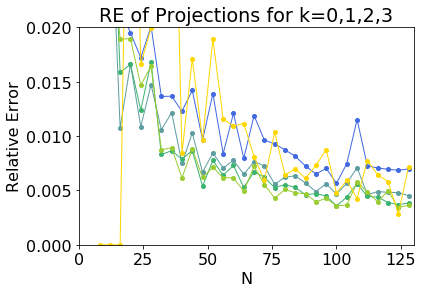

In [47]:
run = 1
if run:
    result = test_projections_unweighted_varying_k("data/signal_and_noise_128.txt", 8)
    for entry in result:
        print(entry)

[0.05808559834579816, 0.041605497114037104, 0.018872400319016266, 0.02288467376815546, 0.014826312295542732, 0.019785767811988132, 0.015384412656503406, 0.014680444266732366, 0.012553940151446475, 0.015935144167354854, 0.009999078592085965, 0.009660601716778036, 0.008646868019874953, 0.010117068891413452, 0.008855415386752264, 0.01177152442937103, 0.009611329522570003, 0.007628125238089634, 0.009714252382421282, 0.009466975762694011, 0.008194233946669254, 0.007002619524476096, 0.00804338020985162, 0.0057133994630251105, 0.006746206101170824, 0.010599262150754185, 0.006833915684610334, 0.0072748784691176495, 0.006632630683516025, 0.006396697074657426, 0.006187163188290871]
[0.08522515484394365, 0.04269852747087836, 0.015967581630736957, 0.012661618616041174, 0.014061631359849492, 0.014047028030645252, 0.0120929553413816, 0.01084941567228449, 0.007610424790804876, 0.010659444229085767, 0.005969566537152339, 0.008028626344583779, 0.006350413526526529, 0.007722129665654908, 0.0060768960558

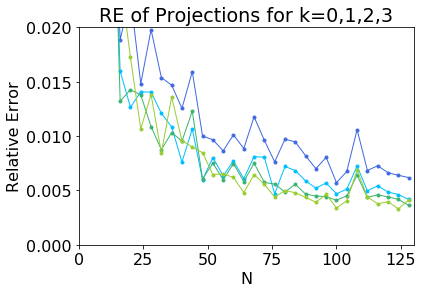

In [63]:
run = 1

if run:
    result = test_projections_weighted_varying_k("data/signal_and_noise_128.txt", 8)
    for entry in result:
        print(entry)